In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from nilearn.connectome import sym_matrix_to_vec
from scipy.stats import pearsonr
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from cmath import isinf
from utils_v import compute_target_score
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, MLP
import random
from scipy.linalg import pinv
from sklearn.utils.extmath import randomized_svd
import time
#from dev_losses import cauchy, rbf, gaussian_kernel, CustomSupCon, CustomContrastiveLoss
#from losses import KernelizedSupCon

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim_feat, input_dim_target, hidden_dim_feat, output_dim, dropout_rate):
        super(MLP, self).__init__()
        
        # Xavier initialization for feature MLP
        self.feat_mlp = nn.Sequential(
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.BatchNorm1d(hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        self.init_weights(self.feat_mlp)

        # Xavier initialization for target MLP
        self.target_mlp = nn.Sequential(
            nn.Linear(input_dim_target, output_dim)
        )
        self.init_weights(self.target_mlp)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x, y):
        features = self.feat_mlp(x)
        targets = self.target_mlp(y)
        features = nn.functional.normalize(features, p=2, dim=1)
        targets = nn.functional.normalize(targets, p=2, dim=1)
        return features, targets

In [3]:
def mirror_conn(matrix, regions, vecrorize_mat = True):
    """
    Flips the connectivity of specified regions within their hemispheres. Handles both single indices and lists of indices.
    
    :param matrix: The connectivity matrix.
    :param regions: A single index or a list of indices for the regions.
    :return: A 3D array of modified connectivity matrices. Each "slice" corresponds to the matrix after flipping each specified region.
    """
    if not isinstance(regions, list):
        regions = [regions]
    flipped_matrices = []
    
    for index in regions:
        new_matrix = matrix.copy()
        hemisphere_size = matrix.shape[0] // 2
        is_left_hemisphere = index < hemisphere_size
        opposite_index = index + (-1 if is_left_hemisphere else 1) * hemisphere_size
        
        # Flip connectivity for the specified region within its hemisphere
        if is_left_hemisphere:
            new_matrix[index, :hemisphere_size], new_matrix[opposite_index, :hemisphere_size] = \
                new_matrix[opposite_index, :hemisphere_size].copy(), new_matrix[index, :hemisphere_size].copy()
            
        else:
            new_matrix[index, hemisphere_size:], new_matrix[opposite_index, hemisphere_size:] = \
                new_matrix[opposite_index, hemisphere_size:].copy(), new_matrix[index, hemisphere_size:].copy()
            
        if vecrorize_mat:
            new_matrix = sym_matrix_to_vec(new_matrix, discard_diagonal = True)
        flipped_matrices.append(new_matrix)
        
    return np.array(flipped_matrices)

In [4]:
def flip_edge_between_regions(matrix, regions, vectorize_mat=True):
    """
    Flips the connectivity edge between two specified regions across hemispheres.
    Handles pairs of regions or lists of pairs of regions.
    
    :param matrix: The connectivity matrix.
    :param regions: A pair of indices or a list of pairs of indices for the regions.
    :param vectorize_mat: Whether to vectorize the output matrices.
    :return: A 3D array of modified connectivity matrices. Each "slice" corresponds to the matrix after flipping the edge for each specified pair.
    """
    if not isinstance(regions[0], list):
        regions = [regions]
    flipped_matrices = []
    
    for pair in regions:
        new_matrix = matrix.copy()
        hemisphere_size = matrix.shape[0] // 2
        
        # Determine the indices for flipping
        for index1, index2 in [pair]:
            is_left_hemisphere1 = index1 < hemisphere_size
            is_left_hemisphere2 = index2 < hemisphere_size
            
            # Calculate the opposite indices in the other hemisphere
            #opposite_index1 = index1 + (-1 if is_left_hemisphere1 else 1) * hemisphere_size
            #opposite_index2 = index2 + (-1 if is_left_hemisphere2 else 1) * hemisphere_size
            opposite_index1 = index1 + (1 if is_left_hemisphere1 else -1) * hemisphere_size
            opposite_index2 = index2 + (1 if is_left_hemisphere2 else -1) * hemisphere_size

            # Flip the connectivity edge between the specified pairs across hemispheres
            new_matrix[index1, opposite_index2], new_matrix[index2, opposite_index1] = \
                new_matrix[index2, opposite_index1], new_matrix[index1, opposite_index2]
            new_matrix[opposite_index2, index1], new_matrix[opposite_index1, index2] = \
                new_matrix[opposite_index1, index2], new_matrix[opposite_index2, index1]
        
        if vectorize_mat:
            # Assuming 'sym_matrix_to_vec' is a function you have that vectorizes a symmetric matrix
            new_matrix = sym_matrix_to_vec(new_matrix, discard_diagonal=True)
        
        flipped_matrices.append(new_matrix)
        
    return np.array(flipped_matrices)

In [5]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, target_name, transform = None, train=True, train_size = 0.8, test_size=None, test_site = None, regions = None, random_state=42, diagnosis = None):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        # Load the entire dataset
        features = np.load(path_feat)
        norm = np.linalg.norm(features)
        features = features / norm 
        #threshold = np.quantile(features, 0.5)
    
        # Apply thresholding: Set values below the threshold to zero
        #features = np.where(features < threshold, 0, features)
        
        
        participant_data = pd.read_csv(path_target)
        targets = np.expand_dims(participant_data[target_name].values, axis = 1)
        

        # Split the dataset into training and test sets
        if test_site is None:
            train_indices, test_indices = train_test_split(np.arange(len(features)), 
                                                       train_size = train_size,
                                                       test_size=test_size,                
                                                       random_state=random_state)
        else:
            test_indices = participant_data.index[participant_data['dataset'] == test_site].values
            train_indices = np.delete(np.arange(len(features)), test_indices)
        
        if train:
            selected_indices = train_indices
        else:
            selected_indices = test_indices

        #if diagnosis is None:
            #train_indices, test_indices = train_test_split(np.arange(len(features)), 
                                                       #train_size = train_size,
                                                       #test_size=test_size,                
                                                       #random_state=random_state)
        #else:
            #test_indices = participant_data.index[participant_data['diagnosis'] == diagnosis].values
            #train_indices = np.delete(np.arange(len(features)), test_indices)
        
        #if train:
            #selected_indices = train_indices
        #else:
            #selected_indices = test_indices
        
        # Select the subset of data for the current mode (train/test)
        features = features[selected_indices]
        targets = targets[selected_indices]
        

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        
        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        self.n_features = vectorized_feat.shape[-1]
        
        if (train and transform is not None):
            # augmentation only in training mode
            if transform != "copy":
                augmented_features = np.array([self.transform(sample, regions = regions) for sample in features])
                vect_augmented_features = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in augmented_features])

                self.n_views = self.n_views + 1 #augmented_features.shape[1]
                self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
                for sub in range(self.n_sub):
                    self.features[sub, 0, :] = vectorized_feat[sub]
                    #self.features[sub, 1, :] = augmented_features[sub]
                    #before : self.features[sub, 1:, :] = augmented_features[sub]
                    self.features[sub, 1, :] = vect_augmented_features[sub]
            else:
                self.features = np.repeat(np.expand_dims(vectorized_feat, axis = 1), 2, axis=1)
        else:
            self.features = np.expand_dims(vectorized_feat, axis = 1)
            
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.from_numpy(targets).float()
        
        return features, targets
    

In [6]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

def sym_matrix_to_vec(matrix, discard_diagonal=True):
    size = matrix.shape[0]
    if discard_diagonal:
        indices = np.triu_indices(size, k=1)
    else:
        indices = np.triu_indices(size)
    return matrix[indices]

class MatData_2(Dataset):
    def __init__(self, features, targets, transform=None, regions=None):
        """
        Initializes the dataset to handle features and targets directly.

        Args:
            features (np.ndarray): Numpy array of feature data.
            targets (np.ndarray): Numpy array of target data.
            transform (callable): A transformation function to apply for augmentation.
        """
        norm = np.linalg.norm(features)
        features = features / norm  # Normalization

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = np.expand_dims(targets, axis=1)

        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        self.n_features = vectorized_feat.shape[-1]
        
        if transform is not None:
            # augmentation only when transform is provided
            augmented_features = np.array([transform(sample, regions=regions) for sample in features])
            vect_augmented_features = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in augmented_features])

            self.n_views += 1  # assuming each sample is augmented once
            self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
            for sub in range(self.n_sub):
                self.features[sub, 0, :] = vectorized_feat[sub]
                self.features[sub, 1, :] = vect_augmented_features[sub]
        else:
            self.features = np.expand_dims(vectorized_feat, axis=1)

    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.from_numpy(targets).float()
        
        return features, targets


In [7]:
def standardize_dataset(dataset):
    all_features_flat = torch.cat([dataset[i][0].view(-1, dataset[i][0].shape[-1]) for i in range(len(dataset))], dim=0)
    all_targets = torch.cat([dataset[i][1].unsqueeze(0) for i in range(len(dataset))], dim=0)
    
    features_mean = all_features_flat.mean(dim=0)
    features_std = all_features_flat.std(dim=0)
    
    features_std[features_std == 0] = 1
    standardized_features_list = []
    
    for i in range(len(dataset)):
        features = dataset[i][0].view(-1, dataset[i][0].shape[-1])
        standardized_features = (features - features_mean) / features_std
        standardized_features_list.append(standardized_features.view(dataset[i][0].shape))
    
    standardized_features = torch.stack(standardized_features_list)
    
    standardized_dataset = TensorDataset(standardized_features, all_targets)
    
    return standardized_dataset

In [8]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

def rbf(x, krnl_sigma):
        x = x - x.T
        return torch.exp(-(x**2)/(2*(krnl_sigma**2)))

In [9]:
!pwd

/storage/store2/work/mrenaudi/contrastive-reg-1


In [10]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
print(device)

cuda


In [12]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon_2(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str, temperature: float=0.07, contrast_mode: str='all',
                 base_temperature: float=0.07, krnl_sigma: float = 1., kernel: callable=None, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.krnl_sigma = krnl_sigma
        self.delta_reduction = delta_reduction

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        contrast_count = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, krnl_sigma = self.krnl_sigma)     
        
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            contrast_feature = features[:, 0]
            anchor_count = 1
            mask = mask.repeat(anchor_count, contrast_count)[:, 0]  # Update mask for contrast mode one

        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
            mask = mask.repeat(anchor_count, contrast_count)
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        #mask = mask.repeat(anchor_count, contrast_count)
        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*anchor_count, device=device).view(-1, 1),
            0
        )
        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))


        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()
    

In [13]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
# the rest is arbitrary
hidden_dim_feat = 1000
input_dim_target = 1
output_dim = 2
num_epochs = 100

lr = 0.01 # too low values return nan loss
kernel = cauchy
batch_size = 30 # too low values return nan loss
dropout_rate = 0
weight_decay = 0

In [14]:
path_matrix = "/storage/store/work/dwassermann/data/victoria_mat_age/matrices.npy"
path_participants = "/storage/store/work/dwassermann/data/victoria_mat_age/data_mat_age_demian/participants.csv"

In [15]:
matrix = np.load(path_matrix)

In [16]:
participants = pd.read_csv(path_participants)

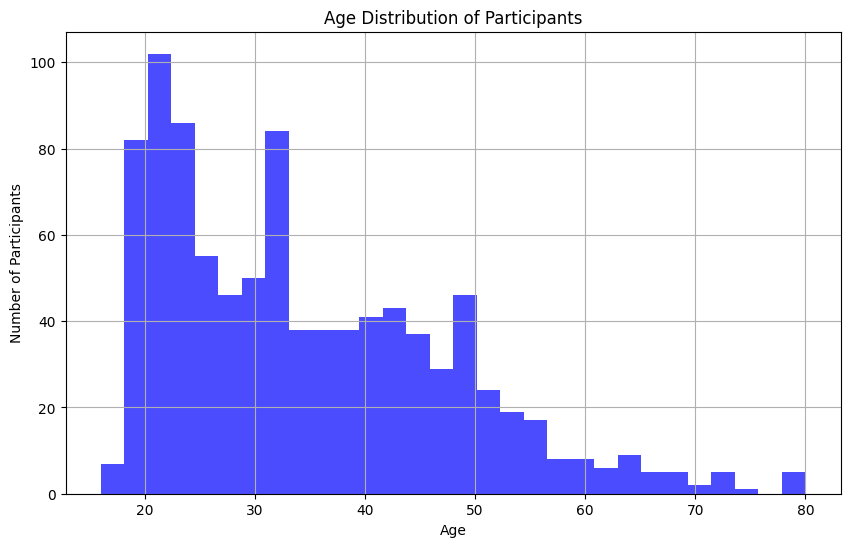

In [17]:
ages = participants['age']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=30, color='blue', alpha=0.7)
plt.title('Age Distribution of Participants')
plt.xlabel('Age')
plt.ylabel('Number of Participants')
plt.grid(True)
plt.show()

In [18]:
import pandas as pd


# Filter the DataFrame to find participants who are 21 years old
participants_21 = participants[participants['age'] == 80]

# Get the indices of these participants
indices_of_21_year_olds = participants_21.index.tolist()

# Print the indices
print("Indices of participants who are 21 years old:", indices_of_21_year_olds)


Indices of participants who are 21 years old: [871]


In [19]:

def augment_sample(matrix, threshold_quantile=0.8):
    # Calculate the threshold using the quantile
    threshold = np.quantile(np.abs(matrix), threshold_quantile)
    
    # Apply thresholding: Set values below the threshold to zero
    features_thresholded = np.where(np.abs(matrix) > threshold, matrix, np.zeros_like(matrix))
    return features_thresholded

def gaussian_kernel(x, krnl_sigma):
    return np.exp(-(x**2) / (2 * (krnl_sigma**2))) / (np.sqrt(2 * np.pi) * krnl_sigma)

def compute_kernel_similarity(augmented, original_matrices, krnl_sigma):
    similarities = []
    for matrix in original_matrices:
        # Flatten matrices if they are 2D, and use Gaussian Kernel on the flattened version
        augmented_flat = augmented.flatten()
        print('augmented_flat', augmented_flat.shape)
        matrix_flat = matrix.flatten()
        print('matrix_flat', matrix_flat.shape)
        diff = augmented_flat - matrix_flat
        kernel_value = gaussian_kernel(diff, krnl_sigma)
        similarity = np.sum(kernel_value)  # Summing up kernel outputs to get a single similarity score
        similarities.append(similarity)
    return np.array(similarities)

# Example usage
original_matrices = matrix  # 100 samples of 10x10 matrices
sample_index = 871 # augmenting the first sample
original_sample = original_matrices[sample_index]
augmented_sample = augment_sample(original_sample)

krnl_sigma = 2.0  # Sigma for Gaussian kernel, adjust as needed
similarities = compute_kernel_similarity(augmented_sample, original_matrices, krnl_sigma)
most_similar_index = np.argmax(similarities)
print("Most similar to its original:", most_similar_index.item() == sample_index)



augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000

In [24]:
def compute_kernel_similarity_2(augmented, original_matrices, krnl_sigma):
    similarities = []
    #for matrix in original_matrices:
        # Flatten matrices if they are 2D, and use Gaussian Kernel on the flattened version
    augmented_flat = augmented.flatten()
    print('augmented_flat', augmented_flat.shape)
    matrix_flat = original_matrices.flatten()
    print('matrix_flat', matrix_flat.shape)
    diff = augmented_flat - matrix_flat
    kernel_value = gaussian_kernel(diff, krnl_sigma)
    similarity = np.sum(kernel_value)  # Summing up kernel outputs to get a single similarity score
    similarities.append(similarity)
    return np.array(similarities)

In [25]:

# Functions assumed to be defined: augment_sample, gaussian_kernel
def compute_kernel_similarity_2(augmented, original_matrices, krnl_sigma):
    similarities = []
    #for matrix in original_matrices:
        # Flatten matrices if they are 2D, and use Gaussian Kernel on the flattened version
    augmented_flat = augmented.flatten()
    print('augmented_flat', augmented_flat.shape)
    matrix_flat = original_matrices.flatten()
    print('matrix_flat', matrix_flat.shape)
    diff = augmented_flat - matrix_flat
    kernel_value = gaussian_kernel(diff, krnl_sigma)
    similarity = np.sum(kernel_value)  # Summing up kernel outputs to get a single similarity score
    similarities.append(similarity)
    return np.array(similarities)
def l2_normalize(matrix):
    norm = np.linalg.norm(matrix, axis=1, keepdims=True)
    return matrix / norm

# Sorting matrix by age
sorted_indices = participants['age'].argsort()
participants_sorted = participants.iloc[sorted_indices].reset_index(drop=True)
matrix_sorted = matrix[sorted_indices]

# Applying L2 normalization
matrix_normalized = l2_normalize(matrix_sorted)
print('matrix_normalized', matrix_normalized.shape)
# Augmenting every sample
matrix_augmented = np.array([augment_sample(sample) for sample in matrix_normalized])
print('matrix_augmented', matrix_augmented.shape)
# Computing kernel values
num_samples = len(matrix_normalized)
kernel_values = np.zeros((num_samples, 2 * num_samples))  # 2* because comparing to both augmented and unaugmented

for i in range(num_samples):
    for j in range(num_samples):
        kernel_values[i, j] = compute_kernel_similarity_2(matrix_augmented[j], matrix_normalized[i], krnl_sigma)
        kernel_values[i, num_samples + j] = compute_kernel_similarity_2(matrix_normalized[i], matrix_normalized[j], krnl_sigma)

# Aggregate kernel values by age
ages = participants_sorted['age'].unique()
age_kernel_values = np.zeros((len(ages), 2 * len(ages)))

for i, age in enumerate(ages):
    indices = participants_sorted[participants_sorted['age'] == age].index
    if len(indices) == 1:
        age_kernel_values[i, :] = kernel_values[indices[0], :]
    else:
        age_kernel_values[i, :] = kernel_values[indices, :].mean(axis=0)

# Resulting matrix dimension
print("Kernel values matrix shape:", age_kernel_values.shape)
print(age_kernel_values)


matrix_normalized (936, 1000, 1000)
matrix_augmented (936, 1000, 1000)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)


/tmp/ipykernel_35582/771611326.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kernel_values[i, j] = compute_kernel_similarity_2(matrix_augmented[j], matrix_normalized[i], krnl_sigma)
/tmp/ipykernel_35582/771611326.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kernel_values[i, num_samples + j] = compute_kernel_similarity_2(matrix_normalized[i], matrix_normalized[j], krnl_sigma)


augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000000,)
matrix_flat (1000000,)
augmented_flat (1000

KeyboardInterrupt: 

In [29]:
unaugmented_flat = matrix_normalized.reshape(936, -1)
augmented_flat = matrix_augmented.reshape(936, -1)
unaugmented_flat = torch.tensor(unaugmented_flat, dtype=torch.float32)  # Ensure dtype is appropriate
augmented_flat = torch.tensor(augmented_flat, dtype=torch.float32)
unaugmented_flat = unaugmented_flat.to(device)
augmented_flat = augmented_flat.to(device)

differences = unaugmented_flat[:, None, :] - augmented_flat[None, :, :]


# Define the kernel width sigma
krnl_sigma = 1.0  # Adjust this parameter based on your specific needs

# Apply the Gaussian kernel function to the squared differences
kernel_values = gaussian_kernel(differences, krnl_sigma).sum(dim=2)
# Sum over the last dimension to collapse the results back to a matrix of shape (936, 936)
#kernel_values = gaussian_kernel.sum(dim=2)

print(kernel_values)


OutOfMemoryError: CUDA out of memory. Tried to allocate 3263.71 GiB. GPU 0 has a total capacity of 31.75 GiB of which 8.64 GiB is free. Process 14173 has 1.40 GiB memory in use. Process 36072 has 13.94 GiB memory in use. Including non-PyTorch memory, this process has 7.76 GiB memory in use. Of the allocated memory 6.97 GiB is allocated by PyTorch, and 2.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [31]:
from numba import jit


In [17]:
import numpy as np

# Functions assumed to be defined: augment_sample, gaussian_kernel
#@jit(nopython=True)

def compute_kernel_similarity_matrix(augmented_matrices, original_matrices, krnl_sigma):
    # Vectorized computation of kernel values between two sets of matrices
    augmented_flat = augmented_matrices.reshape(augmented_matrices.shape[0], -1)
    original_flat = original_matrices.reshape(original_matrices.shape[0], -1)
    
    # Compute differences using broadcasting
    diff = augmented_flat[:, np.newaxis, :] - original_flat[np.newaxis, :, :]
    
    # Apply Gaussian kernel to each difference vector
    kernel_values = gaussian_kernel(diff, krnl_sigma)
    
    # Sum along the last dimension to get a single similarity score per pair
    return kernel_values.sum(axis=2)
#@jit(nopython=True)


def l2_normalize(matrix):
    norm = np.linalg.norm(matrix, axis=(1, 2), keepdims=True)
    return matrix / norm
#@jit(nopython=True)

def augment_sample(matrix, threshold_quantile=0.8):
    # Calculate the threshold using the quantile
    threshold = np.quantile(np.abs(matrix), threshold_quantile)
    
    # Apply thresholding: Set values below the threshold to zero
    features_thresholded = np.where(np.abs(matrix) > threshold, matrix, np.zeros_like(matrix))
    return features_thresholded
#@jit(nopython=True)

def gaussian_kernel(x, krnl_sigma):
    return np.exp(-(x**2) / (2 * (krnl_sigma**2))) / (np.sqrt(2 * np.pi) * krnl_sigma)

In [30]:


# Assume 'participants' and 'matrix' are defined
# Sorting matrix by age
sorted_indices = participants['age'].argsort()
participants_sorted = participants.iloc[sorted_indices].reset_index(drop=True)
matrix_sorted = matrix[sorted_indices]

# Applying L2 normalization
matrix_normalized = l2_normalize(matrix_sorted)

# Augmenting every sample
matrix_augmented = np.array([augment_sample(sample) for sample in matrix_normalized])

# Computing kernel values
kernel_values = np.zeros((len(matrix_normalized), 2 * len(matrix_normalized)))
kernel_values[:, :len(matrix_normalized)] = compute_kernel_similarity_matrix(matrix_augmented, matrix_normalized, krnl_sigma)
kernel_values[:, len(matrix_normalized):] = compute_kernel_similarity_matrix(matrix_normalized, matrix_normalized, krnl_sigma)

# Aggregate kernel values by age
ages = participants_sorted['age'].unique()
age_kernel_values = np.zeros((len(ages), 2 * len(ages)))

for i, age in enumerate(ages):
    indices = participants_sorted[participants_sorted['age'] == age].index
    if len(indices) == 1:
        age_kernel_values[i, :] = kernel_values[indices[0], :]
    else:
        age_kernel_values[i, :] = kernel_values[indices, :].mean(axis=0)

print("Kernel values matrix shape:", age_kernel_values.shape)


In [18]:
sorted_indices = participants['age'].argsort()
participants_sorted = participants.iloc[sorted_indices].reset_index(drop=True)
matrix_sorted = matrix[sorted_indices]


In [19]:
matrix_normalized = l2_normalize(matrix_sorted)


In [20]:
matrix_augmented = np.array([augment_sample(sample) for sample in matrix_normalized])


In [21]:
krnl_sigma = 2
kernel_values = np.zeros((len(matrix_normalized), 2 * len(matrix_normalized)))


In [33]:
kernel_values[:, :len(matrix_normalized)] = compute_kernel_similarity_matrix(matrix_augmented, matrix_normalized, krnl_sigma)


MemoryError: Allocation failed (probably too large).

In [22]:
num_samples = matrix_normalized.shape[0]
batch_size = 10  # Example batch size; adjust based on your system capabilities


In [22]:


# Assuming matrix_normalized and matrix_augmented are already defined
num_samples = matrix_normalized.shape[0]
batch_size = 10  # Example batch size; adjust based on your system capabilities

# Initialize the kernel values matrix
kernel_values = np.zeros((num_samples, 2 * num_samples))

# Current time before starting the loop
start_time = time.time()

# Process in batches
for start_idx in range(0, num_samples, batch_size):
    end_idx = min(start_idx + batch_size, num_samples)
    batch_augmented = matrix_augmented[start_idx:end_idx]
    
    # Compute kernel similarity for the batch against all normalized matrices
    kernel_values[start_idx:end_idx, :num_samples] = compute_kernel_similarity_matrix(
        batch_augmented, matrix_normalized, krnl_sigma
    )

    # Progress tracking
    progress_percentage = (end_idx / num_samples) * 100
    elapsed_time = time.time() - start_time
    estimated_total_time = (elapsed_time / end_idx) * num_samples
    remaining_time = estimated_total_time - elapsed_time

    print(f"Processed {end_idx}/{num_samples} samples ({progress_percentage:.2f}% complete).")
    print(f"Elapsed time: {elapsed_time:.2f} seconds.")
    print(f"Estimated total time: {estimated_total_time:.2f} seconds.")
    print(f"Estimated remaining time: {remaining_time:.2f} seconds.\n")


KeyboardInterrupt: 

In [28]:

kernel_values[:, len(matrix_normalized):] = compute_kernel_similarity_matrix(matrix_normalized, matrix_normalized, krnl_sigma)

MemoryError: Unable to allocate 6.37 TiB for an array with shape (936, 936, 1000000) and data type float64

In [22]:
matrix_normalized[1].flatten().shape

(1000000,)

In [23]:
matrix_augmented[1].flatten().shape

(1000000,)

In [14]:
def random_threshold_augmentation(features, regions = None):
    # Calculate the 95th percentile threshold
    threshold = np.quantile(features, 0.8)
    
    # Apply thresholding: Set values below the threshold to zero
    features_thresholded = np.where(np.abs(features) >threshold, 0, features)
    
    # Generate random values between 0 and the threshold wherever there are zeros
    random_values = np.random.uniform(0, threshold/10, features.shape)
    augmented_features = np.where(features_thresholded == 0, random_values, features_thresholded)

    # Apply L2 normalization
    norm = np.linalg.norm(augmented_features)
    normalized_features = augmented_features / norm if norm != 0 else augmented_features
    
    
    return normalized_features

In [ ]:
import numpy as np
import pandas as pd

# Assuming necessary functions like augment_sample and gaussian_kernel are defined

def compute_kernel_value(original, augmented, krnl_sigma):
    original_flat = original.flatten()
    augmented_flat = augmented.flatten()
    diff = original_flat - augmented_flat
    kernel_value = gaussian_kernel(diff, krnl_sigma)
    return np.sum(kernel_value)

def l2_normalize(matrix):
    norm = np.linalg.norm(matrix, axis=1, keepdims=True)
    return np.where(norm == 0, matrix, matrix / norm)

# Parameters
krnl_sigma = 2.0

# Sort the participants DataFrame by age and get the sorted indices
sorted_indices = participants['age'].argsort()
participants_sorted = participants.iloc[sorted_indices].reset_index(drop=True)

# Normalize the original matrix
matrix_sorted = matrix[sorted_indices]
matrix_normalized = l2_normalize(matrix_sorted)

# Initialize the list for storing kernel values along with ages
kernel_values = []

# Process each normalized and sorted sample
for i in range(len(matrix_normalized)):
    original_sample = matrix_normalized[i]
    augmented_sample = augment_sample(original_sample)  # One augmentation

    # Compute kernel value for the augmented version
    kernel_value = compute_kernel_value(original_sample, augmented_sample, krnl_sigma)
    kernel_values.append((participants_sorted['age'].iloc[i], kernel_value))

# Create a DataFrame from the list of tuples
kernel_df = pd.DataFrame(kernel_values, columns=['Age', 'Kernel Value'])

# Group by 'Age' and calculate mean and standard deviation
result_stats = kernel_df.groupby('Age')['Kernel Value'].agg(['mean', lambda x: np.std(x, ddof=0) if len(x) > 1 else 0])
result_stats.columns = ['Average Kernel Value', 'Standard Deviation']

# Display the results
print(result_stats)


In [14]:
random_threshold_augmentation(matrix).shape

NameError: name 'matrix' is not defined

In [15]:
def flipping_threshold_augmentation(features, regions=None, hemisphere_size=None):
    threshold = np.quantile(features, 0.95)
    
    # Apply thresholding: Set values below the threshold to zero
    features_thresholded = np.where(features < threshold, 0, features)

    # Retrieve index of regions under the threshold
    zero_indices = np.argwhere(features_thresholded == 0)

    # Define hemisphere size if not provided
    if hemisphere_size is None:
        hemisphere_size = features.shape[0] // 2

    # Randomly select index of region to flip
    # Ensure the selection across hemispheres
    if zero_indices.size > 0:
        selected_pairs = []
        for idx in zero_indices:
            region1 = idx[0]
            if region1 < hemisphere_size:
                opposite_region = region1 + hemisphere_size
            else:
                opposite_region = region1 - hemisphere_size

            # Check if the opposite region is also under threshold
            if features_thresholded[opposite_region, idx[1]] == 0:
                selected_pairs.append([region1, opposite_region])
                break  # Select only one pair for this example

        # Flip the selected regions 
        if selected_pairs:
            flipped_matrices = flip_edge_between_regions(features, selected_pairs)
            return flipped_matrices
    return features
    


In [16]:
def flipping_threshold_augmentation_2(features, regions=None, hemisphere_size=None):
    threshold = np.quantile(features, 0.95)
    
    # Apply thresholding: Set values below the threshold to zero
    features_thresholded = np.where(features < threshold, 0, features)

    # Retrieve index of regions under the threshold
    zero_indices = np.argwhere(features_thresholded == 0)

    if hemisphere_size is None:
        hemisphere_size = features.shape[0] // 2

    if zero_indices.size > 0:
        selected_idx = random.choice(zero_indices)
        selected_pairs = []
        
        region1 = selected_idx[0]
        if region1 < hemisphere_size:
            opposite_region = region1 + hemisphere_size
        else:
            opposite_region = region1 - hemisphere_size

        # Check if the opposite region is also under threshold
        if features_thresholded[opposite_region, selected_idx[1]] == 0:
            selected_pairs.append([region1, opposite_region])

        # Flip the selected regions in the original matrix
        if selected_pairs:
            flipped_matrices = flip_edge_between_regions(features, selected_pairs)
            return flipped_matrices
    
    return features



In [17]:
flipping_threshold_augmentation_2(matrix[0]).shape

NameError: name 'matrix' is not defined

In [18]:


def SVD_augmentation(X, k=10, noise_factor=0.05, n_iter=5, regions = None):
    """
    Augment data by adding noise to the k smallest singular values of matrix X using randomized SVD.

    Parameters:
    X (numpy.ndarray): The original data matrix.
    k (int): The number of smallest singular values to augment.
    noise_factor (float): The scalar factor to control the amount of noise added.
    n_iter (int): The number of power iterations in randomized SVD.

    Returns:
    numpy.ndarray: The augmented data matrix.
    """
    # Compute the pseudo-inverse of X
    X_pinv = pinv(X)

    # Apply randomized SVD to the pseudo-inverse matrix
    U, Sigma, VT = randomized_svd(X_pinv, n_components=k, n_iter=n_iter, random_state=None)

    # Add noise to the singular values
    Sigma += noise_factor * np.random.normal(size=Sigma.shape)

    # Reconstruct the pseudo-inverse matrix with modified singular values
    X_pinv_augmented = np.dot(U, np.dot(np.diag(Sigma), VT))

    # Inverse the pseudo-inverse to get the augmented original matrix
    X_augmented = pinv(X_pinv_augmented)  

    return X_augmented


In [19]:
def SVD_augmentation_2(X, k=10, noise_factor=0.05, n_iter=5, regions = None):
    """
    Augment data by adding noise to the k smallest singular values of matrix X using randomized SVD.

    Parameters:
    X (numpy.ndarray): The original data matrix.
    k (int): The number of smallest singular values to augment.
    noise_factor (float): The scalar factor to control the amount of noise added.
    n_iter (int): The number of power iterations in randomized SVD.

    Returns:
    numpy.ndarray: The augmented data matrix.
    """
    # Compute the pseudo-inverse of X
    X_pinv = pinv(X)

    # Apply randomized SVD to the pseudo-inverse matrix
    U, Sigma, VT = randomized_svd(X_pinv, n_components=k, n_iter=n_iter, random_state=None)
    
    # Add noise to the singular values
    Sigma += noise_factor * np.random.normal(size=Sigma.shape)
    original_Sigma = 1/Sigma
    original_U = np.transpose(U)
    original_V = np.transpose(VT)
    

    X_augmented = np.dot(original_V, np.dot(np.diag(original_Sigma), original_U))

    return X_augmented

In [20]:
import numpy as np
from sklearn.neighbors import KernelDensity


def get_mixup_sample_rate(args, data_packet, kernel="gaussian",bandwidth=1.0):
    mix_idx = []
    _, y_list = data_packet['x_train'], data_packet['y_train'] 
    N = len(data_list)

    ######## use kde rate or uniform rate #######
    for i in range(N):
        data_i = data_list[i]
        data_i = data_i.reshape(-1,data_i.shape[0])
        kd = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(data_i)
        each_rate = np.exp(kd.score_samples(data_list))
        each_rate /= np.sum(each_rate)  
        mix_idx.append(each_rate)

    mix_idx = np.array(mix_idx)
    self_rate = [mix_idx[i][i] for i in range(len(mix_idx))]

    return mix_idx

In [15]:
train_dataset = MatData(path_matrix, path_participants, "age", transform =random_threshold_augmentation ,test_site = None, diagnosis = None)


In [16]:
test_dataset = MatData(path_matrix, path_participants, "age", train=False, test_site = None, diagnosis = None)


In [17]:
#standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [18]:
#standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
class LabelDifference(nn.Module):
    def __init__(self, distance_type='l1'):
        super(LabelDifference, self).__init__()
        self.distance_type = distance_type

    def forward(self, labels):
        # labels: [bs, label_dim]
        # output: [bs, bs]
        if self.distance_type == 'l1':
            return torch.abs(labels[:, None, :] - labels[None, :, :]).sum(dim=-1)
        else:
            raise ValueError(self.distance_type)


class FeatureSimilarity(nn.Module):
    def __init__(self, similarity_type='l2'):
        super(FeatureSimilarity, self).__init__()
        self.similarity_type = similarity_type

    def forward(self, features):
        # labels: [bs, feat_dim]
        # output: [bs, bs]
        if self.similarity_type == 'l2':
            return - (features[:, None, :] - features[None, :, :]).norm(2, dim=-1)
        else:
            raise ValueError(self.similarity_type)


class RnCLoss(nn.Module):
    def __init__(self, temperature=2, label_diff='l1', feature_sim='l2'):
        super(RnCLoss, self).__init__()
        self.t = temperature
        self.label_diff_fn = LabelDifference(label_diff)
        self.feature_sim_fn = FeatureSimilarity(feature_sim)

    def forward(self, features, labels):
        # Guard against NaNs in input
        assert not torch.isnan(features).any(), "Features contain NaNs"
        assert not torch.isnan(labels).any(), "Labels contain NaNs"

        features = torch.cat([features[:, 0], features[:, 1]], dim=0)  # [2bs, feat_dim]
        labels = labels.repeat(2, 1)  # [2bs, label_dim]

        label_diffs = self.label_diff_fn(labels)
        logits = self.feature_sim_fn(features).div(self.t)
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits -= logits_max.detach()
        exp_logits = torch.exp(logits - torch.max(logits))  # additional stabilization step

        n = logits.shape[0]  # n = 2bs

        # remove diagonal
        mask = (1 - torch.eye(n, device=logits.device)).bool()
        logits = logits.masked_select(mask).view(n, n - 1)
        exp_logits = exp_logits.masked_select(mask).view(n, n - 1)
        label_diffs = label_diffs.masked_select(mask).view(n, n - 1)

        loss = 0.
        for k in range(n - 1):
            pos_logits = logits[:, k]
            pos_label_diffs = label_diffs[:, k]
            neg_mask = (label_diffs >= pos_label_diffs.view(-1, 1)).float()
            exp_logits_sum = torch.clamp((neg_mask * exp_logits).sum(dim=-1), min=1e-10)  # avoid log(0)
            pos_log_probs = pos_logits - torch.log(exp_logits_sum)
            loss += - (pos_log_probs / (n * (n - 1))).sum()

        return loss

In [20]:
# torch.cuda.empty_cache()
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, output_dim, dropout_rate).to(device)
criterion_pft = KernelizedSupCon_2(method='expw', temperature=0.03, base_temperature=0.07, kernel=kernel, krnl_sigma = 1, contrast_mode = 'all')
criterion_ptt = KernelizedSupCon_2(method='expw', temperature=0.03, base_temperature=0.07, kernel=kernel, krnl_sigma = 1, contrast_mode = 'all')
#criterion_pft = RnCLoss(temperature=0.01)
#criterion_ptt = RnCLoss(temperature=0.01)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        bsz = targets.shape[0]
        n_views = features.shape[1]
        n_feat = features.shape[-1]
        
        features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
        features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]
        
        optimizer.zero_grad()
        out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0)) # ([bsz*5, 1], [bsz*5, 1])
        
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]
        
        loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]
        loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])
    
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')


Epoch 0 | Mean Loss 6.166686630249023
Epoch 1 | Mean Loss 4.702699890136719
Epoch 2 | Mean Loss 3.760547609329224
Epoch 3 | Mean Loss 3.5185248374938967


KeyboardInterrupt: 

## Evaluation

In [33]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import multiprocessing

@torch.no_grad()
def gather_feats_targets(model, dataloader, device):
    features = []
    targets = []

    model.eval()
    for idx, (feat, target) in enumerate(dataloader):
        if len(feat.shape) > 2:
            feat = feat[:, 0, :]
        feat = feat.to(device)
        target = target.to(device)
        out_feat, out_target= model(feat, target)
        features.append(out_feat)
        targets.append(target[:, 0])
    
    return torch.cat(features, 0).cpu().numpy(), torch.cat(targets, 0).cpu().numpy()

@torch.no_grad()
def estimate_age(model, train_loader, test_loader, device):
    age_estimator = AgeEstimator()
    X_train, y_train = gather_feats_targets(model, train_loader, device)
    age_estimator.fit(X_train, y_train)
    y_pred_train = age_estimator.predict(X_train)
    X_test, y_test = gather_feats_targets(model, test_loader, device)
    y_pred_test = age_estimator.predict(X_test)
    return y_train, y_test, y_pred_train, y_pred_test

@torch.no_grad()
def compute_age_mae_r2(model, train_loader, test_loader, device): # test_int, test_ext, opts
    age_estimator = AgeEstimator()

    print("Training age estimator")
    train_X, train_y = gather_feats_targets(model, train_loader, device)
    mae_train, r2_train = age_estimator.fit(train_X, train_y)
    X_test, y_test = gather_feats_targets(model, test_loader, device)
    #ext_X, ext_y = gather_age_feats(model, test_ext, opts)
    mae_test = age_estimator.score(X_test, y_test)
    r2_test = age_estimator.r2(X_test, y_test)
    # mae_ext = age_estimator.score(ext_X, ext_y)

    return mae_train, r2_train, mae_test, r2_test # mae, r2 for train and test

class AgeEstimator(BaseEstimator):
    """ Define the age estimator on latent space network features.
    """
    def __init__(self):
        n_jobs = multiprocessing.cpu_count()
        self.age_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10.**np.arange(-2, 3)}, cv=5,
            scoring="r2", n_jobs=n_jobs)

    def fit(self, X, y):
        self.age_estimator.fit(X, y)
        return self.score(X, y), self.r2(X, y)

    def predict(self, X):
        y_pred = self.age_estimator.predict(X)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return mean_absolute_percentage_error(y, y_pred)
    
    def r2(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return r2_score(y, y_pred)

In [34]:
age_train, age_test, age_pred_train, age_pred_test = estimate_age(model, std_train_loader, std_test_loader, device)

X_train, y_train = gather_feats_targets(model, std_train_loader, device)
X_test, y_test = gather_feats_targets(model, std_test_loader, device)

df_train = pd.DataFrame({"Y_Train":age_train, "Y_Train_Pred":age_pred_train})
df_test = pd.DataFrame({"Y_Test": age_test, "Y_Test_Pred":age_pred_test})

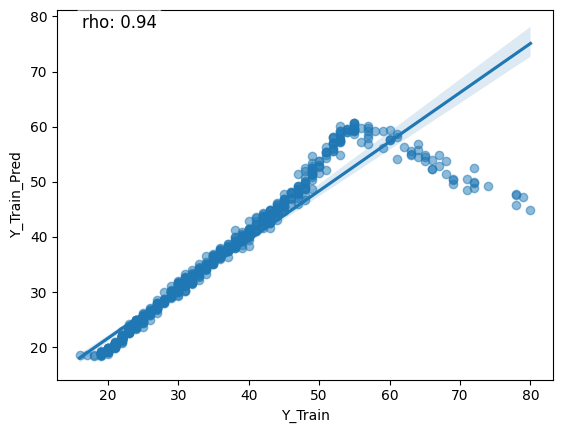

In [35]:

corr, _ = pearsonr(df_train['Y_Train'], df_train['Y_Train_Pred'])
corr_text = f'rho: {corr:.2f}'
sns.regplot(x='Y_Train', y='Y_Train_Pred', data=df_train, scatter_kws={'alpha':0.5})
plt.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
plt.show()

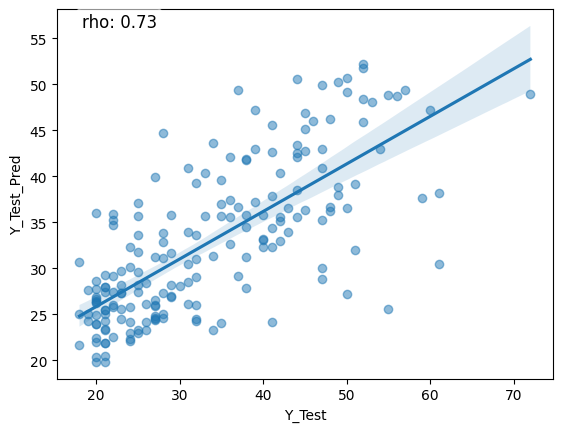

In [36]:
corr, _ = pearsonr(df_test['Y_Test'], df_test['Y_Test_Pred'])
corr_text = f'rho: {corr:.2f}'
sns.regplot(x='Y_Test', y='Y_Test_Pred', data=df_test, scatter_kws={'alpha':0.5})
plt.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
plt.show()

<Axes: xlabel='Y_Test', ylabel='Y_Err_perc'>

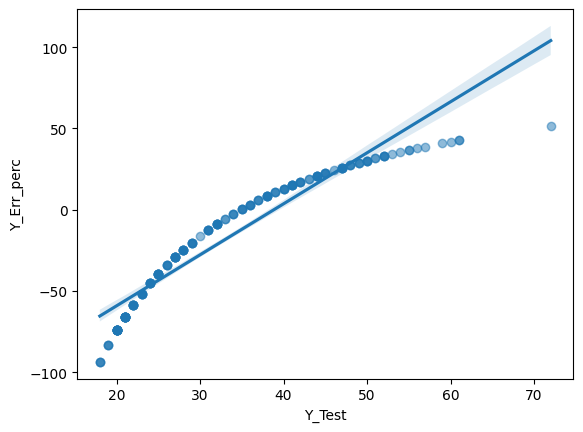

In [30]:
sns.regplot(x='Y_Test', y='Y_Err_perc', data=df_test.eval("Y_Err_perc = (Y_Test - Y_Test_Pred) / Y_Test * 100"), scatter_kws={'alpha':0.5})

In [31]:
mape_train, r2_train, mape_test, r2_test = compute_age_mae_r2(model, std_train_loader, std_test_loader, device)
print(f"Train Age MAPE: {mape_train}, Test Age MAPE: {mape_test}.")
print(f"Train Age R2: {r2_train}, Test Age R2: {r2_test}.")

Training age estimator
Train Age MAPE: 0.33882763981819153, Test Age MAPE: 0.3470425307750702.
Train Age R2: 1.064961540397924e-06, Test Age R2: -0.01389966948792698.


## Testing

In [32]:
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# features = torch.vstack([test_dataset[i][0] for i in range(len(test_loader))])
# targets = torch.vstack([test_dataset[i][1] for i in range(len(test_loader))])
# features_mean, features_std, targets_mean, targets_std = compute_global_stats(test_dataset)
# standardized_features = (features - features_mean) / features_std
# standardized_targets = (targets - targets_mean) / targets_std
# standardized_test_dataset = TensorDataset(standardized_features, standardized_targets)
# test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [33]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_test_loader):
        bsz = targets.shape[0]
        n_views = 1
        n_feat = features.shape[-1]
        
        if len(features.shape) > 2:
            n_views = features.shape[1]
            features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
        features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]

        out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0))   
        
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]
        
        loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])
        
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]
        
        loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])
        
        emb_features.append(out_feat[:, 0, :])
        emb_targets.append(out_target[:, 0, :])
        
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   2.58


In [107]:
emb_features = torch.row_stack(emb_features).cpu()

In [108]:
emb_targets = torch.row_stack(emb_targets).cpu()

In [109]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [110]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [111]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


TypeError: seaborn.utils._scatter_legend_artist() got multiple values for keyword argument 'label'

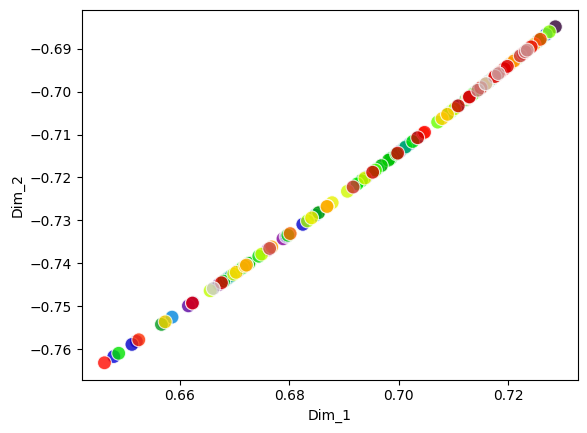

In [112]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
# plt.xlim(-0.1, 0.1)
# plt.ylim(0.98, 1)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])